In [22]:
import torch
import random
import importlib


# Local imports modules
import classes.Simulation as Simulation
import classes.Systems as Systems
import classes.PID as PID

# Reload modules
importlib.reload(Simulation)
importlib.reload(Systems)
importlib.reload(PID)

# Local import reloaded classes
from classes.Simulation import Simulation
from classes.Systems import Trolley, ContinuousTankHeating 
from classes.PID import PID

In [1]:
import tqdm
import matplotlib.pyplot as plt

# Trolley simulation

In [23]:
DT = torch.tensor(0.01)
TIME = torch.arange(0, 200, DT)
TARGET = torch.ones_like(TIME) * 10
DISTRUBANCE = torch.zeros_like(TIME)

# Change target
TARGET[TIME > 50] = 20
TARGET[TIME > 100] = 0
TARGET[TIME > 150] = 10

# Create a PID controller
Kp = torch.tensor(1.)
Ki = torch.tensor(0.1)
Kd = torch.tensor(1)
pid = PID(KP=Kp, KI=Ki, KD=Kd)

# Create a system
mass = torch.tensor(2)
friction = torch.tensor(0.2)
system = Trolley(mass=mass, friction=friction, dt=DT)

Run the simulation

In [ ]:
feedback_Loss = torch.zeros_like(TIME)
feedback_Kp = torch.zeros_like(TIME)
feedback_Ki = torch.zeros_like(TIME)
feedback_Kd = torch.zeros_like(TIME)
feedback_x = torch.zeros_like(TIME)
feedback_u = torch.zeros_like(TIME)

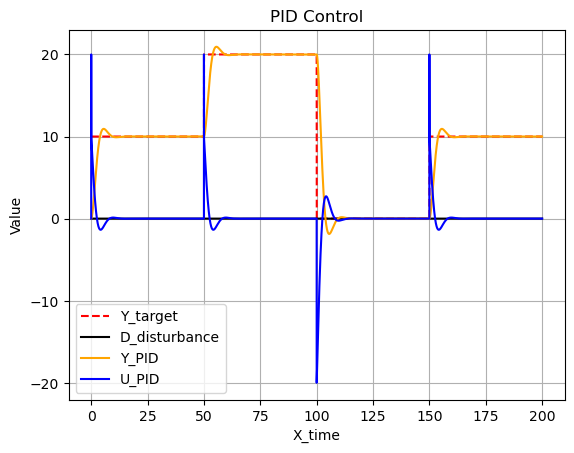

In [24]:
TARGET[TIME>40] = random.uniform(0, 15)
TARGET[TIME>80] = random.uniform(0, 15)
TARGET[TIME>100] = random.uniform(0, 15)

# Time loop
with tqdm.notebook.tqdm(total=len(TIME)) as pbar:
    with torch.no_grad():

        for idx in range(1, len(TIME)):
            
            target = TARGET[idx]
            distrubance = DISTRUBANCE[idx]
            position = system.get_position()

            #------------- PREDICTION -------------#
            # Predict the gains: Kp, Ki, Kd
            prediction = pidnn(torch.tensor([target, position]))
            Kp, Ki, Kd = prediction

            # Set the gains
            with torch.no_grad():
                pid.Kp.copy_(Kp)
                pid.Ki.copy_(Ki)
                pid.Kd.copy_(Kd)

            # Compute the control output
            control_output = pid.compute(position, TARGET, DT)

            #------------- SYSTEM -------------#
            # Compute the new position
            trolley.apply_control(control_output, DISTRUBANCE)
            # Compute the error
            new_position = trolley.get_position()
            error = TARGET - new_position


            # Update the progress bar
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.4f}")
            pbar.set_postfix({"Kp": Kp.item(), "Ki": Ki.item(), "Kd": Kd.item()})
        

            #------------- FEEDBACK -------------#
            # Loss
            feedback_Loss[idx] = error
            
            # Gains
            feedback_Kp[idx] = Kp.item()
            feedback_Ki[idx] = Ki.item()
            feedback_Kd[idx] = Kd.item()

            # System
            feedback_x[idx] = new_position.item()
            feedback_u[idx] = control_output.item()

## Simulation of tank heating

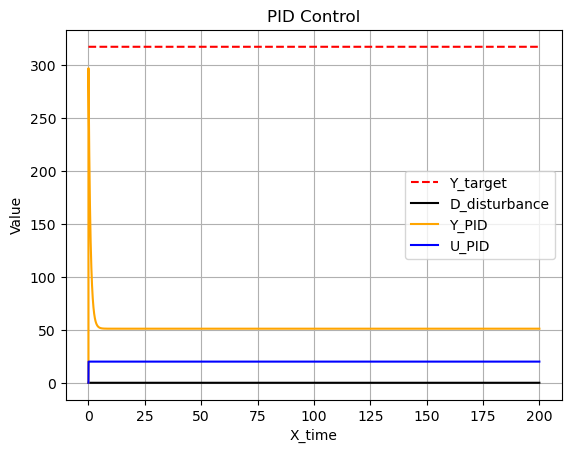

In [25]:
# Initialize the system parameters
DT = torch.tensor(0.01)
TIME = torch.arange(0, 200, DT)
TARGET = torch.ones_like(TIME) * 317.5
DISTRUBANCE = torch.zeros_like(TIME)

# PID parameters
Kp = torch.tensor(1.)
Ki = torch.tensor(0.1)
Kd = torch.tensor(1)

# Create a PID controller and a system
pid = PID(KP=Kp, KI=Ki, KD=Kd)
tank = ContinuousTankHeating(dt=DT)

# Create a simulation environment
sim = Simulation(TIME, TARGET, DISTRUBANCE, DT)

# Run the simulation and plot the results
sim.run(tank, pid)
sim.plot()